#### Token Unlocks and Price Impacts

This notebook contains the data analysis done for our findings. This notebook is to be run *after* running data_processing.ipynb (for a full workflow instruction set, refer to the README). We use helper functions from the 'utils' folder and standard data science packages. Although we have checked and vetted this code, proceed with caution.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
import statsmodels.api as sm
import scipy
import math
from sklearn.cluster import KMeans
from tabulate import tabulate

Set styles, configure matplotlib and seaborn.

In [2]:
plt.style.use('seaborn-pastel')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  
custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4)]

SMALL_SIZE = 12
MEDIUM_SIZE = 17
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 

plt.rcParams['axes.grid'] = True


Import private and public token vesting data.

In [3]:
private = dict()
with pd.ExcelFile('data/daily_unlocks/daily_tables_internal.xlsx') as f:
    names = f.sheet_names
    for name in names:
        private[name] = f.parse(name)

public = dict()
with pd.ExcelFile('data/daily_unlocks/daily_tables_external.xlsx') as f:
    names = f.sheet_names
    for name in names:
        public[name] = f.parse(name)



### Private and Public Tokens

After importing both public and private tokens, we plot them with separate tags and regression lines.

The processing method for raw token data is process_price_supply_lists(), which takes in a dictionary of token data, a window of analysis, and a threshold (limit) for the supply that we trim our data to. First, we set those constants and run our processing.

In [4]:
from utils.window_analysis import process_price_supply_lists

WINDOW = 0 # number of days before and after unlock

# filter out datapoints outside of thresholds
PRICE_THRESHOLD = (-math.inf, math.inf) 
 # lower bound cannot be negative, 20 to account for outliers
SUPPLY_THRESHOLD = (0, 20)

public_prices, public_supplies = process_price_supply_lists(public, WINDOW, SUPPLY_THRESHOLD)
private_prices, private_supplies = process_price_supply_lists(private, WINDOW, SUPPLY_THRESHOLD)


prices: 2244, supplies:  2244
prices: 5529, supplies:  5529


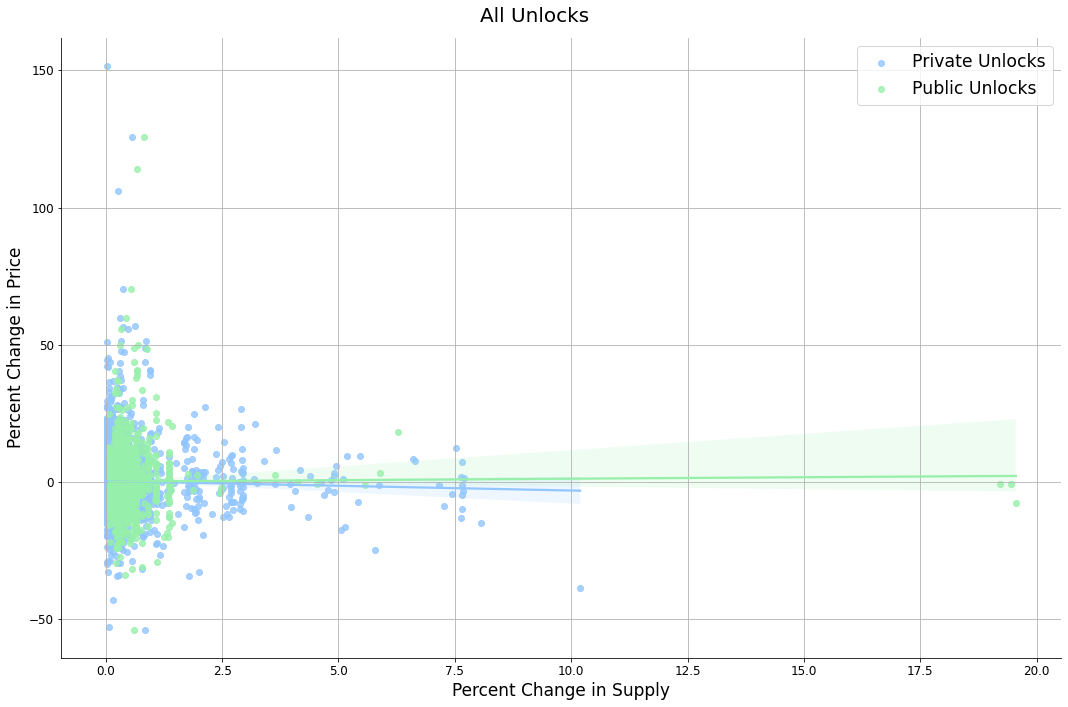

In [5]:
# clean out NaNs and conver to numpy arrays
priv_X = np.nan_to_num(np.array(private_supplies))
priv_y = np.nan_to_num(np.array(private_prices))

pub_X = np.nan_to_num(np.array(public_supplies))
pub_y = np.nan_to_num(np.array(public_prices))

# store in dicts for seaborn
data_private = pd.DataFrame({
    "Percent Change in Supply": priv_X,
    "Percent Change in Price": priv_y,
})

data_public = pd.DataFrame({
    "Percent Change in Supply": pub_X,
    "Percent Change in Price": pub_y,
})

data_private["Unlock Type"] = "Private Unlocks"
data_public["Unlock Type"] = "Public Unlocks"

# concatenate datasets
data = pd.concat([data_private, data_public])


g = sns.lmplot(x="Percent Change in Supply", y="Percent Change in Price", data=data, fit_reg=True, hue='Unlock Type', legend=False)

g.fig.set_size_inches(15, 10)
plt.suptitle("All Unlocks")
plt.legend(fontsize='x-large', title_fontsize='40')
plt.tight_layout()

In [6]:
# omit public tokens and reassign to private
tokens = private

### Aggregate Graph for the Dataset

First, we'll plot every unlock on one chart and find the average and median changes in the 30 days surrounding an unlock.

In [7]:
from utils.aggregate_analysis import norm_windows, get_stat_lines
# normalize all data by percent change from day of unlock
# plot all on the same chart with x-axis showing days from unlock, ranging [-15, 15]

unlock_windows = []
window = 15

for token in tokens:
    prices = tokens[token]["price"]
    supplies = tokens[token]["p_change_supply"]
    
    for i, s in enumerate(supplies):
        rules = [s > 0.5, i in range(window, len(prices) - window + 1)]
        
        if all(rules):
            unlock_windows.append(prices[i - window: i + window + 1])

new_index = range(-window, window + 1)     

for s in unlock_windows:
    s.index = new_index

normalized_windows = norm_windows(unlock_windows, window)
avg_line, median_line = get_stat_lines(normalized_windows, window)

Once calculated, we plot.

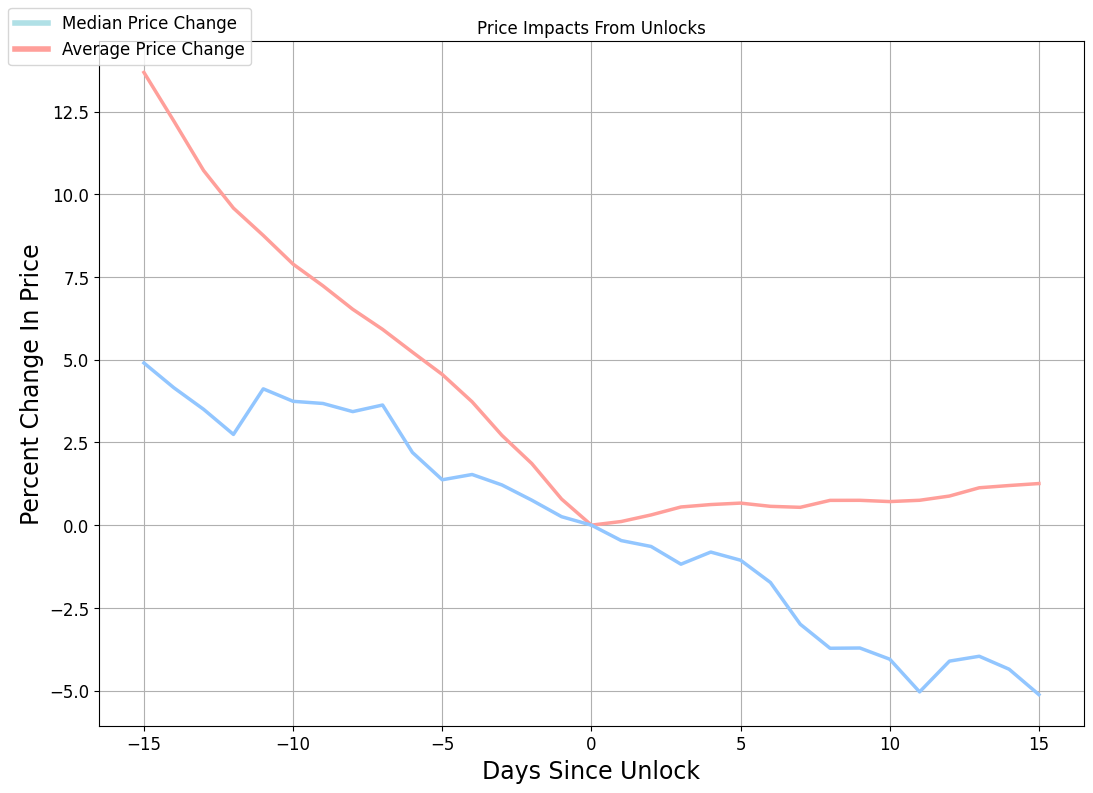

In [8]:
fig, ax = plt.subplots(figsize=(11, 8))
plt.title("Price Impacts From Unlocks")
plt.xlabel("Days Since Unlock")
plt.ylabel("Percent Change In Price")


plt.plot(avg_line, color=colors[2], linewidth=2.5)
plt.plot(median_line, color=colors[0], linewidth=2.5)

custom_lines = [Line2D([0], [0], color=colors[5], lw=4),
                Line2D([0], [0], color=colors[2], lw=4)]

fig.legend(custom_lines, ["Median Price Change", "Average Price Change"], loc="upper left")
fig.set_facecolor('white')
plt.tight_layout()
plt.show()

### Correlation Analysis

#### Same-Day Analysis

We begin our correlation analysis with a single day analysis, calculating the change in price from the day before the unlock to the day after the unlock. This means setting our window to 0.

In [9]:
WINDOW = 0 
PRICE_THRESHOLD = (-math.inf, math.inf) 
SUPPLY_THRESHOLD = (0, 20)

prices, supplies = process_price_supply_lists(tokens, WINDOW, SUPPLY_THRESHOLD)

prices: 5529, supplies:  5529


We'll be using this type of chart a lot, so we define a function to plot it.

In [10]:
def supply_price_chart(prices, supplies, title, saveFilePath=None):
    """
    method to graph a regression line and scatter plot for price and supply data.

    prices (list) : price data
    supplies (list): supply data
    title (String): title for chart

    saveFilePath (Boolean) : parameter to save image if desired

    returns None
    """

    # clean data and turn into numpy arrays
    X = np.nan_to_num(np.array(supplies))
    y = np.nan_to_num(np.array(prices))

    data = pd.DataFrame({
        "Percent Change in Supply": X,
        "Percent Change in Price": y,
    })

    # plot using seaborn regplot
    plt.figure(figsize=(9, 6))
    plt.suptitle(title)
    
    sns.regplot(x="Percent Change in Supply", y="Percent Change in Price", 
    line_kws={"color": "green"}, data=data, fit_reg=True)
    

    # annotate with r^2 and regression line eq.
    slope, intercept, r_val, p_val, std_err = scipy.stats.linregress(X, y)
    
    plt.annotate("r^2 = {:.3f}".format(r_val**2), xy=(.7, .8), fontsize=12, 
    xycoords='axes fraction')
    
    plt.annotate("y = {:.3f}x + {:.3f}".format(slope, intercept), xy=(.7, .7), 
    fontsize=12, xycoords='axes fraction')

    plt.tight_layout()

    if saveFilePath:
        plt.savefig(saveFilePath, dpi=12000)

    # print some summary stats
    print(title)
    table = [["Slope", "Inctercept", "R squared", "Standard Error"], 
            [slope, intercept, r_val**2, std_err]]

    print(tabulate(table))
    
    


Now we're ready to plot

All Private Unlocks
--------------------  ------------------  ---------------------  ------------------
Slope                 Inctercept          R squared              Standard Error
-0.34478015853001936  0.2822402737398193  -0.025081476034706916  0.1848450375209523
--------------------  ------------------  ---------------------  ------------------


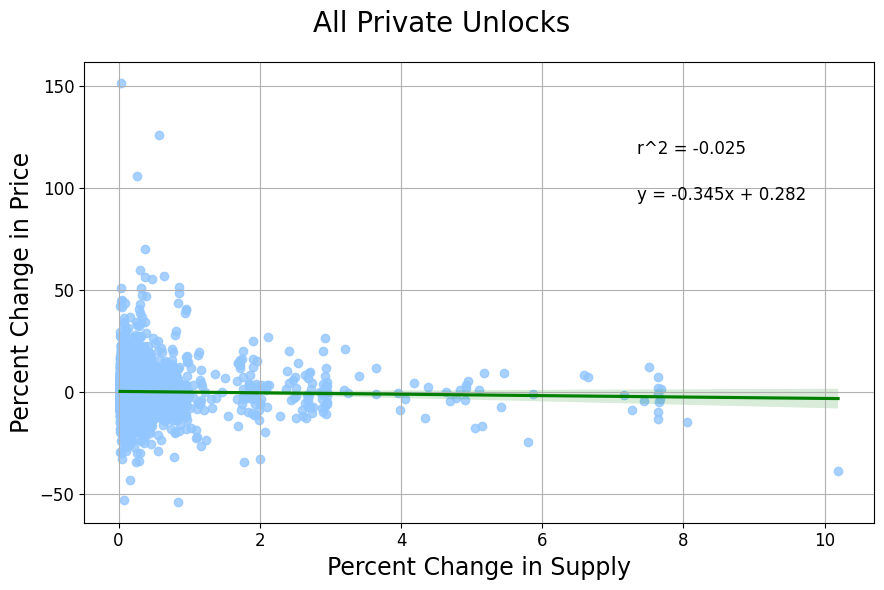

In [11]:
supply_price_chart(prices, supplies, "All Private Unlocks")

We notice two clusters, one between 0-1% of supply and everything greater than 1%. We adjust our supply threshold and plot both charts. Note that we allow for some noise by making the threshold slightly larger for the cluster greater than 1%. 

We denote cluster_one as between 0% and 1% and cluster_two as greater than 1%. 

prices: 5344, supplies:  5344
prices: 213, supplies:  213
Unlocks Between 0% and 1%
------------------  -------------------  --------------------  ------------------
Slope               Inctercept           R squared             Standard Error
1.0471761566371076  0.04411092153321966  0.022321597730048555  0.6417033472827502
------------------  -------------------  --------------------  ------------------
Unlocks Greater than 1%
-------------------  ------------------  -------------------  -------------------
Slope                Inctercept          R squared            Standard Error
-0.7676922686452448  1.6324636508621424  -0.1244872484289621  0.42123997361855936
-------------------  ------------------  -------------------  -------------------


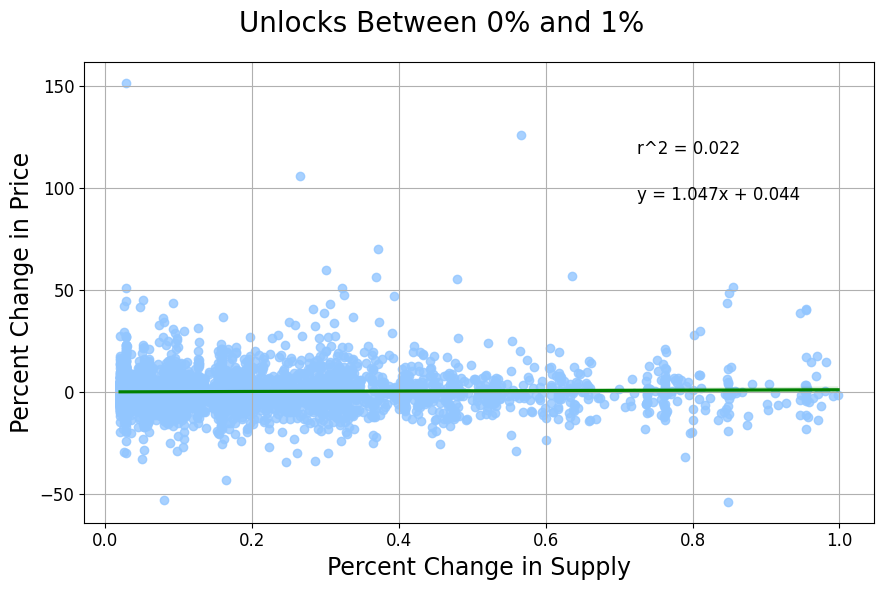

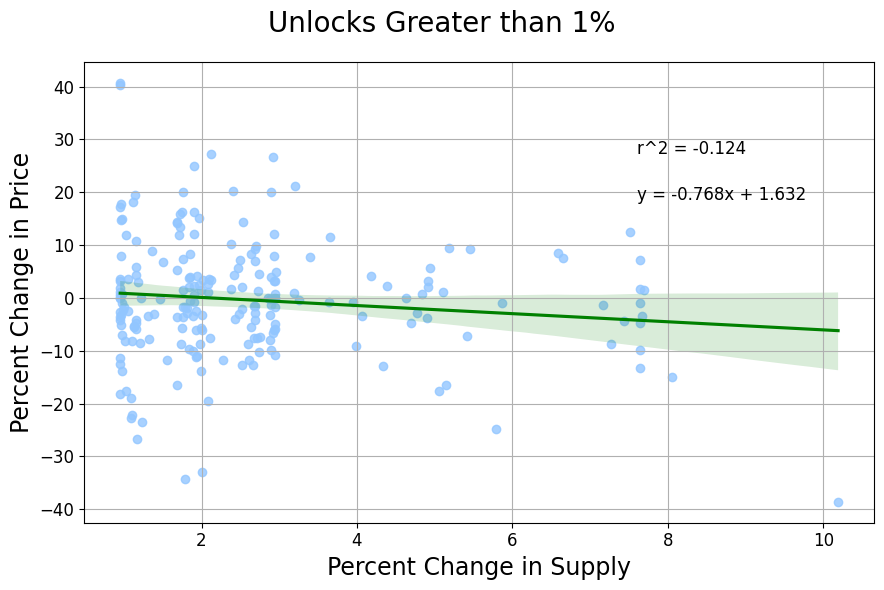

In [12]:
CLUSTER_ONE_SUPPLY_THRESHOLD = (0, 1) 
CLUSTER_TWO_SUPPLY_THRESHOLD = (0.95, 20)

cluster_one_prices, cluster_one_supplies = process_price_supply_lists(tokens, WINDOW, CLUSTER_ONE_SUPPLY_THRESHOLD)
cluster_two_prices, cluster_two_supplies = process_price_supply_lists(tokens, WINDOW, CLUSTER_TWO_SUPPLY_THRESHOLD)

supply_price_chart(cluster_one_prices, cluster_one_supplies, "Unlocks Between 0% and 1%")
supply_price_chart(cluster_two_prices, cluster_two_supplies, "Unlocks Greater than 1%")

### Longer Windows

We look at several days before and after the day of the unlock, measuring the change in price from the day of unlock and again plotting against the relative size of the unlocks. We perform the same process on 3, 7, and 15 day windows.

##### 3 Day Window

prices: 206, supplies:  206
prices: 215, supplies:  215
3 Days Before
------------------  -----------------  ------------------  ------------------
Slope               Inctercept         R squared           Standard Error
2.7375676509631277  -1.07968364682519  0.1808816837272059  1.0421535121810823
------------------  -----------------  ------------------  ------------------
3 Days After
-------------------  ------------------  ---------------------  ------------------
Slope                Inctercept          R squared              Standard Error
-0.3824852741095325  1.2846563420133752  -0.030676014118860253  0.8539285874114805
-------------------  ------------------  ---------------------  ------------------


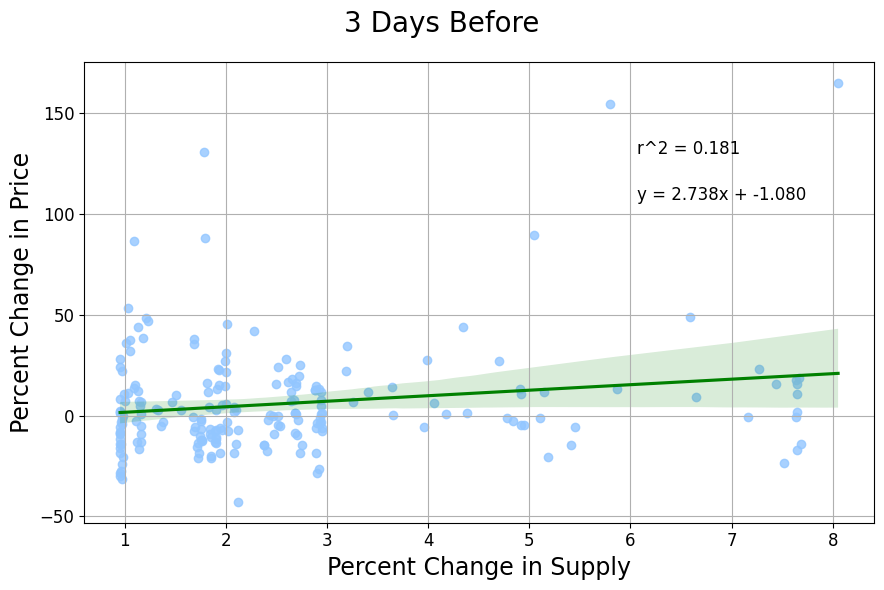

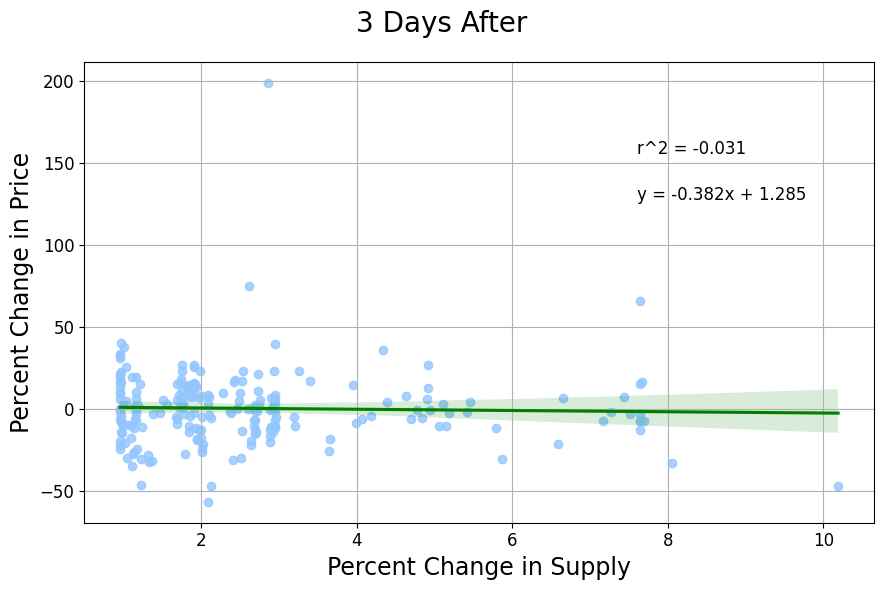

In [13]:
SUPPLY_THRESHOLD = (.95, 20)

before_prices_three, before_supplies_three = process_price_supply_lists(tokens, -3, SUPPLY_THRESHOLD)
after_prices_three, after_supplies_three = process_price_supply_lists(tokens, 3, SUPPLY_THRESHOLD)

supply_price_chart(before_prices_three, before_supplies_three, "3 Days Before")
supply_price_chart(after_prices_three, after_supplies_three, "3 Days After")

#### 7 Day Window

prices: 197, supplies:  197
prices: 215, supplies:  215
7 Days Before
-----------------  -------------------  -------------------  ------------------
Slope              Inctercept           R squared            Standard Error
5.155138095701009  -3.0589276744881317  0.22186441443635502  1.6224618539199365
-----------------  -------------------  -------------------  ------------------
7 Days After
-------------------  -----------------  --------------------  ------------------
Slope                Inctercept         R squared             Standard Error
-1.4853486734787829  4.446250347815954  -0.10284647496016396  0.9843286222455359
-------------------  -----------------  --------------------  ------------------


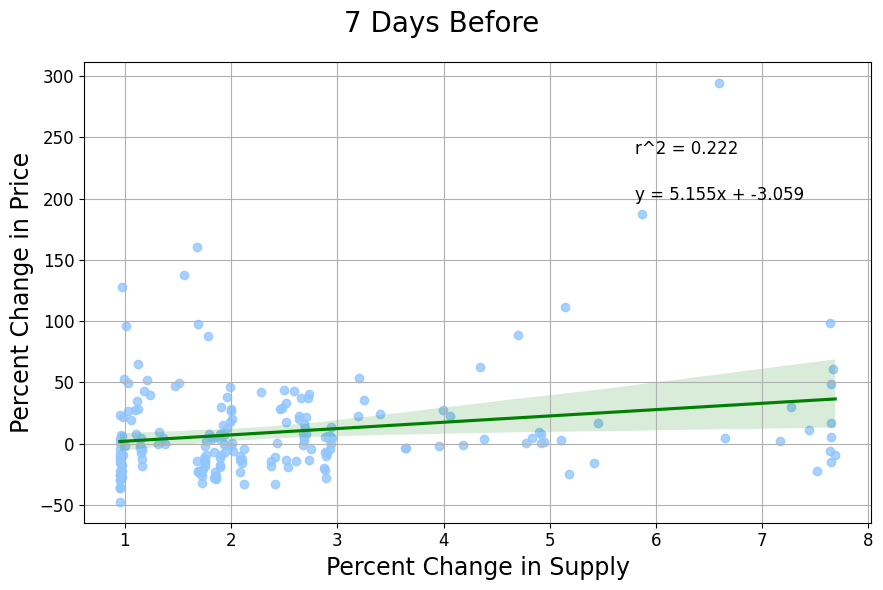

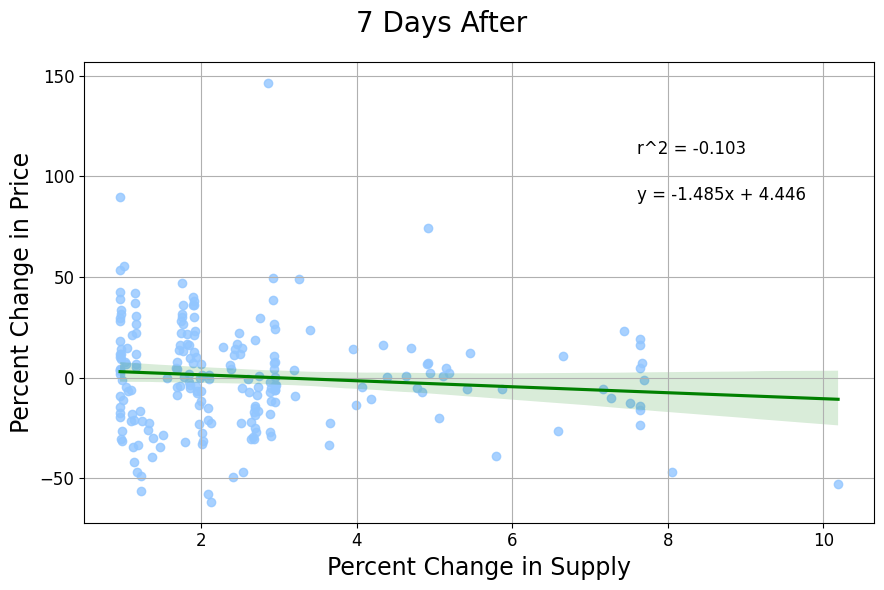

In [14]:
before_prices_seven, before_supplies_seven = process_price_supply_lists(tokens, -6, SUPPLY_THRESHOLD)
after_prices_seven, after_supplies_seven = process_price_supply_lists(tokens, 6, SUPPLY_THRESHOLD)

supply_price_chart(before_prices_seven, before_supplies_seven, "7 Days Before")
supply_price_chart(after_prices_seven, after_supplies_seven, "7 Days After")

#### 15 Day Window

prices: 177, supplies:  177
prices: 215, supplies:  215
15 Days Before
-------------------  ------------------  ---------------------  -----------------
Slope                Inctercept          R squared              Standard Error
-0.5967269397159285  19.244223339602023  -0.017269755041556877  2.611594049688264
-------------------  ------------------  ---------------------  -----------------
15 Days After
-------------------  -----------------  -------------------  ------------------
Slope                Inctercept         R squared            Standard Error
-2.9900671019361162  6.746249413630606  -0.1366234209103477  1.4855059976829261
-------------------  -----------------  -------------------  ------------------


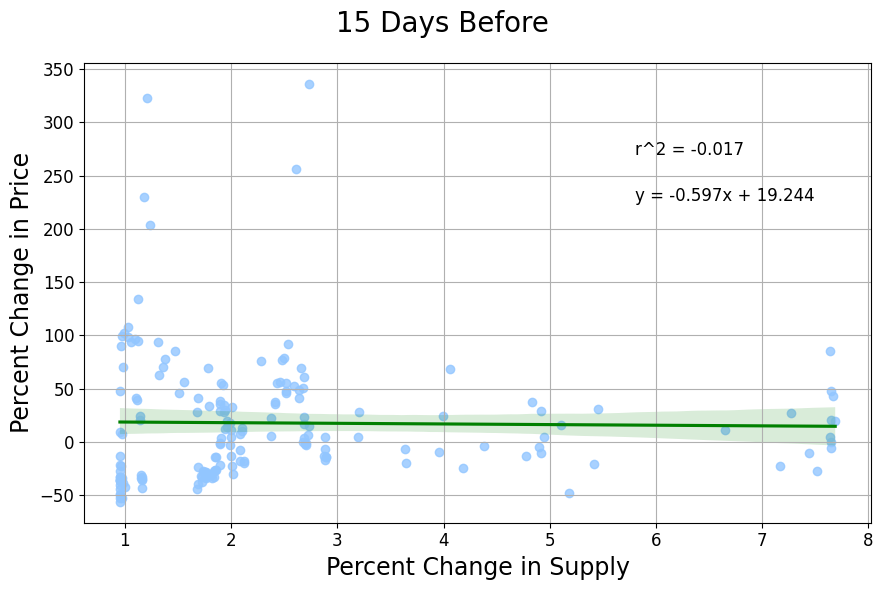

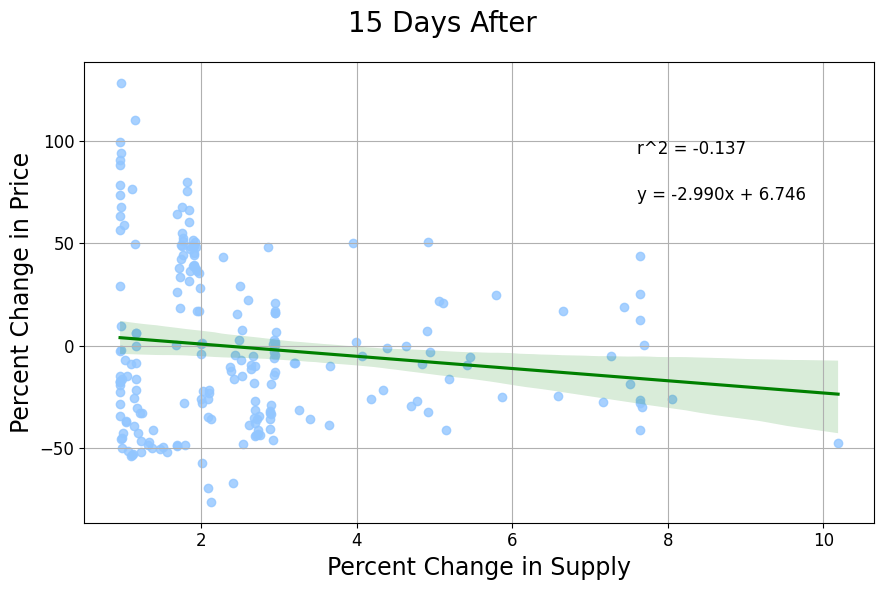

In [15]:
before_prices_fifteen, before_supplies_fifteen = process_price_supply_lists(tokens, -15, SUPPLY_THRESHOLD)
after_prices_fifteen, after_supplies_fifteen = process_price_supply_lists(tokens, 15, SUPPLY_THRESHOLD)

supply_price_chart(before_prices_fifteen, before_supplies_fifteen, "15 Days Before")
supply_price_chart(after_prices_fifteen, after_supplies_fifteen, "15 Days After")

### Vesting Period Length 

We analyze the different stages of vesting periods, analyzing protocols with more than 70% of their tokens vested against those with less than 70%. We collect price data for a given daterange, analyze the volatility (coefficient of variation) and change in price over the time period. We then take an average over both groups for these metrics.

In [16]:
import datetime as dtd
from utils.price_performance import get_token_price_stats, get_macro_stats, aggregrate_price_stats

mostly_vested = ['uniswap', 'bitdao', 'pooltogether', 'merit-circle', 'decentraland', 'looksrare', 'curve-dao-token', 'gelato', 'lido-dao', 'project-galaxy']
mostly_locked = ['nym', 'euler', 'tornado-cash', 'forta', 'sweatcoin', 'stakewise', 'stepn', 'project-galaxy', 'bitdao']

START_DATE = pd.to_datetime("01-15-2023")
END_DATE = pd.to_datetime('04-15-2023')

vested_results, locked_results = get_token_price_stats(mostly_vested, mostly_locked, tokens, START_DATE, END_DATE)

macro_results = get_macro_stats(START_DATE, END_DATE)

results = aggregrate_price_stats(vested_results, locked_results, macro_results)

# create table of results
table = [["", "Mostly Vested", "Mostly Locked", "ETH", "BTC"], 
        ["Variance", results["1"]["variance"], results["2"]["variance"], results["macro"]["eth_variance"], results["macro"]["btc_variance"]],
        ["Price Change", results["1"]["change"], results["2"]["change"], results["macro"]["eth_change"], results["macro"]["btc_change"]]]

print(tabulate(table))  


------------  ------------------  -------------------  -------------------  ------------------
              Mostly Vested       Mostly Locked        ETH                  BTC
Variance      13.117737275506594  34.54883524085829    7.5745570682033625   11.311439994202441
Price Change  0.30568639467599    -0.2095105809542261  0.36009380674247227  0.4564584766898183
------------  ------------------  -------------------  -------------------  ------------------


### Distributions

We perform a similar analysis for tokens with different distributions between public and private groups. We look at tokens with public distributions above and below 63% over different time periods. We start with the same period, from 01-15-23 to 04-15-23.

In [17]:
more_private = ['nym', 'uniswap', 'euler', 'project-galaxy', 'forta', 'stakewise', 'gelato', 'lido-dao', 'filecoin']
more_public = ['bitdao', 'tornado-cash', 'pooltogether', 'merit-circle', 'decentraland', 'looksrare', 'sweatcoin', 'curve-dao-token', 'stepn']

START_DATE = pd.to_datetime("01-15-2023")
END_DATE = pd.to_datetime("04-15-2023")

public_results, private_results = get_token_price_stats(more_public, more_private, tokens, START_DATE, END_DATE)

macro_results = get_macro_stats(START_DATE, END_DATE)

results = aggregrate_price_stats(public_results, private_results, macro_results)

# create table of results
table = [["", "More Public", "More Private", "ETH", "BTC"], 
        ["Variance", results["1"]["variance"], results["2"]["variance"], results["macro"]["eth_variance"], results["macro"]["btc_variance"]],
        ["Price Change", results["1"]["change"], results["2"]["change"], results["macro"]["eth_change"], results["macro"]["btc_change"]]]

print(tabulate(table))


------------  -------------------  -------------------  -------------------  ------------------
              More Public          More Private         ETH                  BTC
Variance      14.44709631020103    14.946123699835564   7.5745570682033625   11.311439994202441
Price Change  0.16700531456037815  0.26109853919669956  0.36009380674247227  0.4564584766898183
------------  -------------------  -------------------  -------------------  ------------------


We do the same for a different time period, from 10-01-22 to 01-01-23.

In [18]:
more_private = ['nym', 'uniswap', 'euler', 'project-galaxy', 'forta', 'stakewise', 'gelato', 'lido-dao', 'filecoin']
more_public = ['bitdao', 'tornado-cash', 'pooltogether', 'merit-circle', 'decentraland', 'looksrare', 'sweatcoin', 'curve-dao-token', 'stepn']

START_DATE = pd.to_datetime("10-01-2022")
END_DATE = pd.to_datetime("01-01-2023")

public_results, private_results = get_token_price_stats(more_public, more_private, tokens, START_DATE, END_DATE)

macro_results = get_macro_stats(START_DATE, END_DATE)

results = aggregrate_price_stats(public_results, private_results, macro_results)

# create table of results
table = [["", "More Public", "More Private", "ETH", "BTC"], 
        ["Variance", results["1"]["variance"], results["2"]["variance"], results["macro"]["eth_variance"], results["macro"]["btc_variance"]],
        ["Price Change", results["1"]["change"], results["2"]["change"], results["macro"]["eth_change"], results["macro"]["btc_change"]]]

print(tabulate(table))

------------  --------------------  -------------------  --------------------  --------------------
              More Public           More Private         ETH                   BTC
Variance      23.52615253745813     18.969529209831155   9.717233001125662     8.804964828315555
Price Change  -0.49718629229866695  -0.3064204316058723  -0.09971287132073899  -0.15075443021024015
------------  --------------------  -------------------  --------------------  --------------------


### Accounting for Macro


#### Adjusting Prices for Market Beta

We use a rolling 30 day Beta. 

In [19]:
def rolling_beta(tokens):
    for token in tokens:
        t = tokens[token]
        t['beta'] = t['p_change_price'].rolling(30).cov(t["p_change_macro"]) / t['p_change_price'].rolling(30).var()
        t['p_change_price'] = t['p_change_price'] - (t['p_change_macro'] * t['beta'])
    
    return tokens

private_beta_adj = rolling_beta(private)


prices: 5544, supplies:  5544
Adjusted Same Day Correlation
--------------------  -------------------  ---------------------  ------------------
Slope                 Inctercept           R squared              Standard Error
0.003683194629975473  0.10433285794899151  0.0002893791423180562  0.1709716743156907
--------------------  -------------------  ---------------------  ------------------


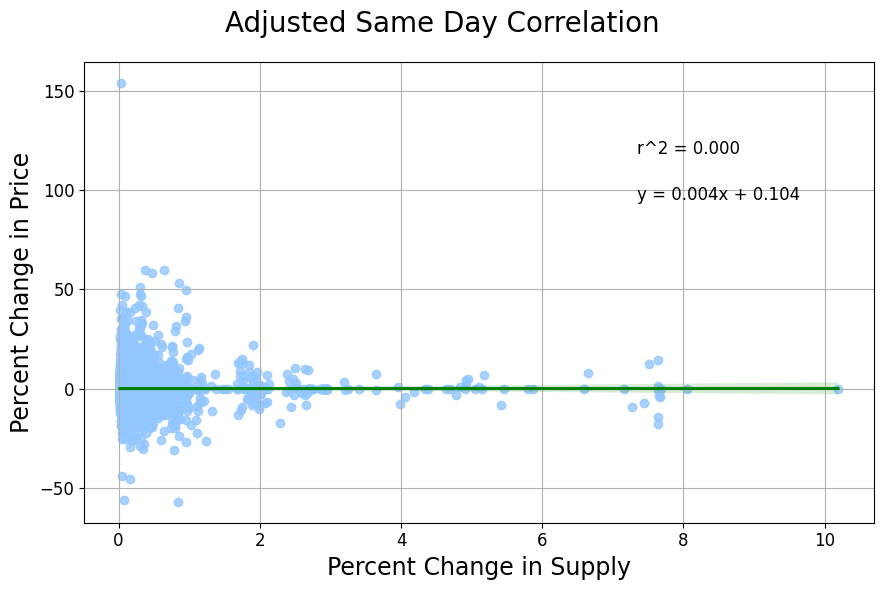

In [25]:
WINDOW = 0 
PRICE_THRESHOLD = (-math.inf, math.inf) 
SUPPLY_THRESHOLD = (0, 20)

prices, supplies = process_price_supply_lists(private_beta_adj, WINDOW, SUPPLY_THRESHOLD)

supply_price_chart(prices, supplies, "Adjusted Same Day Correlation")

prices: 5357, supplies:  5357
Adjusted Same Day Correlation
------------------  -------------------  --------------------  ------------------
Slope               Inctercept           R squared             Standard Error
1.5043008529948836  -0.6528814928208093  0.012931253255634073  1.5895640533857875
------------------  -------------------  --------------------  ------------------


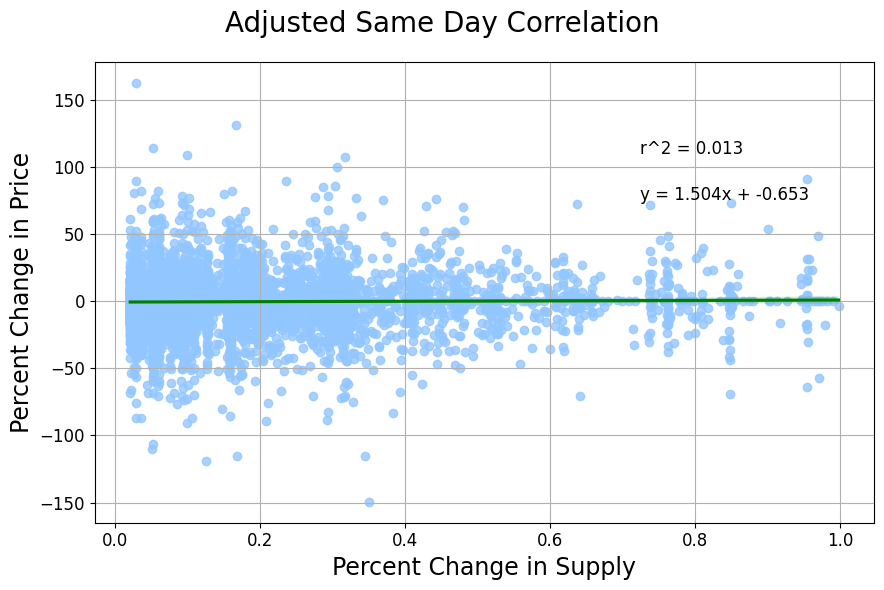

In [45]:
WINDOW = 0 
PRICE_THRESHOLD = (-math.inf, math.inf) 
SUPPLY_THRESHOLD = (0, 1)

prices, supplies = process_price_supply_lists(private_beta_adj, WINDOW, SUPPLY_THRESHOLD)

supply_price_chart(prices, supplies, "Adjusted Same Day Correlation")

prices: 237, supplies:  237
Adjusted Same Day Correlation
-------------------  -----------------  --------------------  ------------------
Slope                Inctercept         R squared             Standard Error
-1.0462090473640782  2.912964887506008  -0.12011120995877421  0.5640861836078499
-------------------  -----------------  --------------------  ------------------


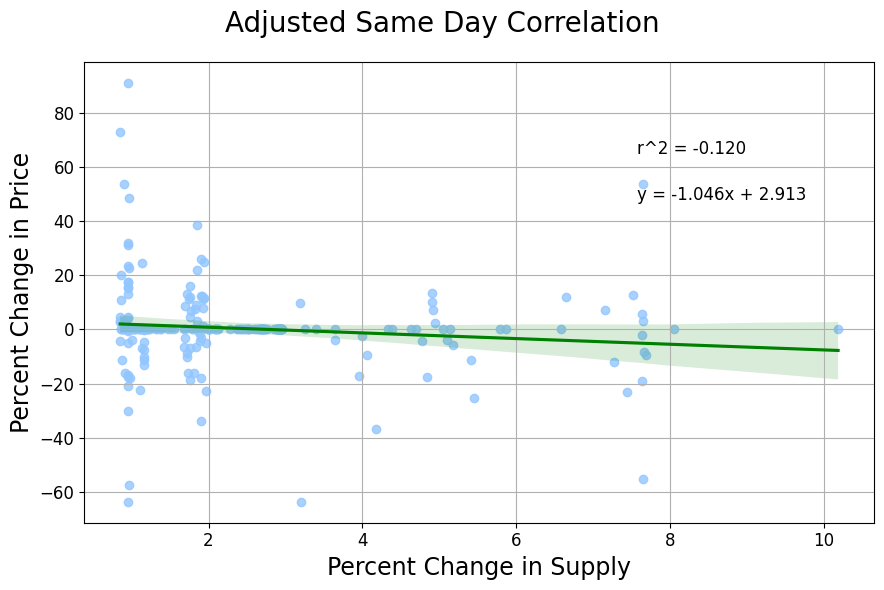

In [46]:
WINDOW = 0 
PRICE_THRESHOLD = (-math.inf, math.inf) 
SUPPLY_THRESHOLD = (.85, 20)

prices, supplies = process_price_supply_lists(private_beta_adj, WINDOW, SUPPLY_THRESHOLD)

supply_price_chart(prices, supplies, "Adjusted Same Day Correlation")

prices: 237, supplies:  237
Adjusted 7 Days After Correlation
-------------------  ------------------  -------------------  ------------------
Slope                Inctercept          R squared            Standard Error
-1.0397638420948103  5.5658426938550525  -0.0834463442409274  0.8099833949297749
-------------------  ------------------  -------------------  ------------------


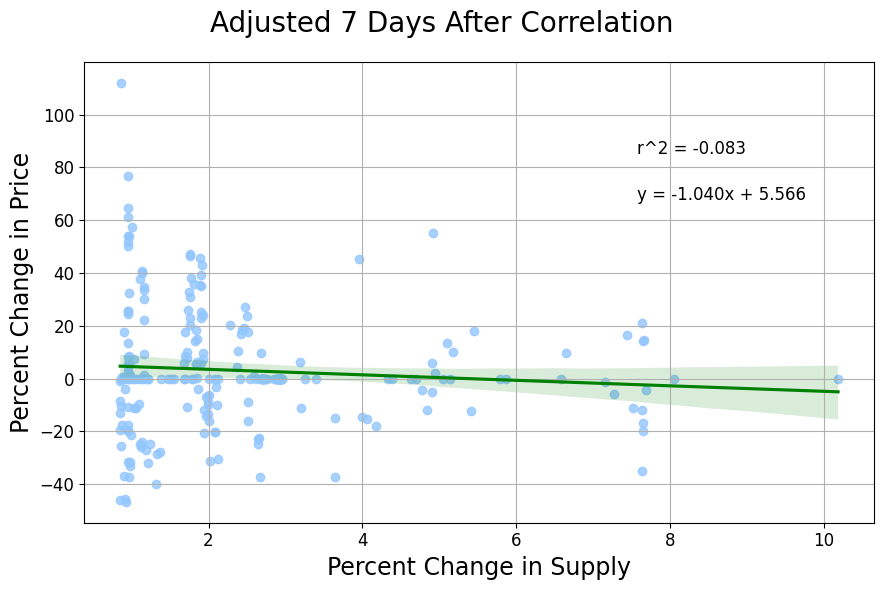

In [23]:
WINDOW = 7 
PRICE_THRESHOLD = (-math.inf, math.inf) 
SUPPLY_THRESHOLD = (.85, 20)

prices, supplies = process_price_supply_lists(private_beta_adj, WINDOW, SUPPLY_THRESHOLD, True)

supply_price_chart(prices, supplies, "Adjusted 7 Days After Correlation")

prices: 216, supplies:  216
Adjusted 7 Days Before Correlation
------------------  -------------------  ------------------  ------------------
Slope               Inctercept           R squared           Standard Error
2.6306719749595042  -3.4849871253634412  0.1985803982968872  0.8875380885696362
------------------  -------------------  ------------------  ------------------


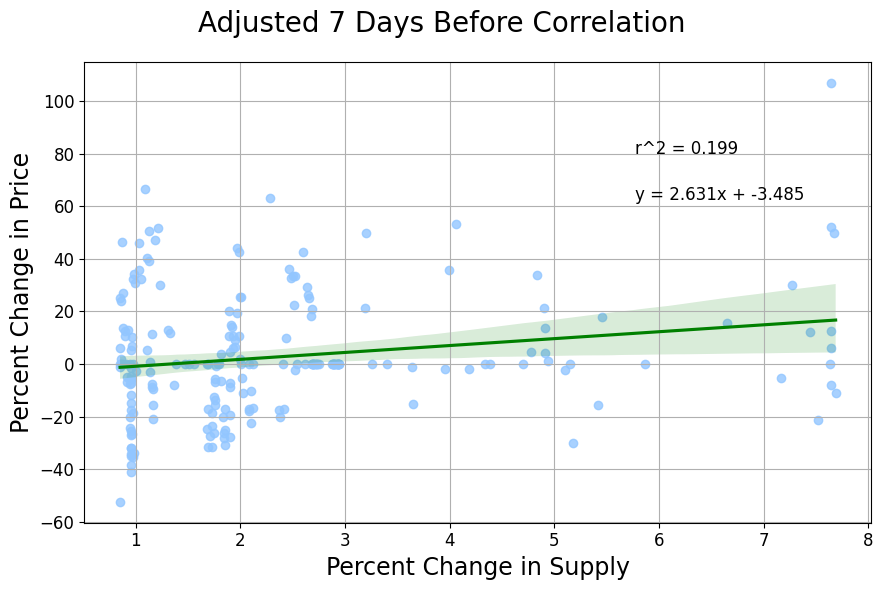

In [24]:
WINDOW = -7 
PRICE_THRESHOLD = (-math.inf, math.inf) 
SUPPLY_THRESHOLD = (.85, 20)

prices, supplies = process_price_supply_lists(private_beta_adj, WINDOW, SUPPLY_THRESHOLD, True)

supply_price_chart(prices, supplies, "Adjusted 7 Days Before Correlation")